# Denoising Stacked Autoencoder

In this notebook, we'll be creating a denoising stacked autoencoder for the FashionMNIST dataset. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import HTML, Image
from matplotlib import animation, rc
from mxnet import autograd, nd, init, context as ctx
from mxnet.gluon import nn, Trainer, loss as gloss
from mxnet.gluon.data import DataLoader
from mxnet.gluon.data.vision import transforms, FashionMNIST

In [2]:
def try_gpu(index=0):
    return ctx.gpu(index) if ctx.num_gpus() > index else ctx.cpu()

Some hyperparameters

In [3]:
batch_size=256

## 1. Loading the FashionMNIST dataset

First, we need to load the FashionMNIST dataset and process it! 

In [4]:
X_train = FashionMNIST()
X_test = FashionMNIST(train=False)

Let's define a noise function

In [5]:
def add_noise(x, noise_rate=0.05):
    x += noise_rate * nd.random.normal(shape=x.shape)
    x = nd.clip(x, a_min=0.0, a_max=1.0)
    return x

Now we define four datasets, original and noisy versions for train and test.

In [6]:
noise_transform = transforms.Compose([
    transforms.ToTensor(),
    add_noise,
])
clear_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [7]:
X_train_noise = DataLoader(
    X_train.transform_first(noise_transform), batch_size=batch_size, shuffle=False, last_batch="keep", 
)
X_train_orig = DataLoader(
    X_train.transform_first(clear_transform), batch_size=batch_size, shuffle=False, last_batch="keep", 
)
X_valid_noise = DataLoader(
    X_test.transform_first(noise_transform), batch_size=batch_size, shuffle=False, last_batch="keep", 
)
X_valid_orig = DataLoader(
    X_test.transform_first(clear_transform), batch_size=batch_size, shuffle=False, last_batch="keep", 
)

## 2. Defining the autoencoder

In [8]:
class Autoencoder(nn.HybridBlock):
    def __init__(self, *args, **kwargs):
        super(Autoencoder, self).__init__(*args, **kwargs)
        self.encoder = nn.HybridSequential()
        self.encoder.add(
            nn.Dense(256, activation="relu"),
            nn.Dense(128, activation="relu"),
            nn.Dense(64, activation="relu"),
        )
        
        self.decoder = nn.HybridSequential()
        self.decoder.add(
            nn.Dense(128, activation="relu"),
            nn.Dense(256, activation="relu"),
            nn.Dense(784, activation="sigmoid")
        )
        
    def hybrid_forward(self, F, X):
        return self.decoder(self.encoder(X))

In [9]:
autoencoder = Autoencoder()
autoencoder.hybridize()
autoencoder.initialize(ctx=try_gpu())

Also, we define the loss function as MSE and SGD as the optimizr.

In [10]:
loss = gloss.L2Loss()
trainer = Trainer(autoencoder.collect_params(), "adam", {"learning_rate": 0.0001})

In [11]:
def plot_image_grid(imgs, ncols, nrows, titles, img_size=5):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(img_size, img_size * ncols))
    axs = axs.ravel()
    
    for title, img, ax in zip(titles, imgs, axs):
        ax.imshow(img, cmap="gray")
        ax.set_xlabel(title)
    
    plt.show()
    
    
def images2gif(imgs, filename):
    fig, ax = plt.subplots()
    img_gif = ax.imshow(progress[0], cmap="gray")
    plt.axis("off")
    def init():
        plt.axis("off")
        plt.imshow(np.zeros((28, 28)), cmap="gray")
        return (img_gif,)
    def animate(i):
        plt.axis("off")
        plt.title(f"Epoch {i}")
        plt.imshow(progress[i], cmap="gray")
        return (img_gif,)
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(progress), interval=500, blit=True)
    anim.save(filename)
    
def evaluate(net, X_valid_noise, X_valid_orig):
    losses = []
    for i, ((X_n, _), (X_o, _)) in enumerate(zip(X_valid_noise, X_valid_orig)):
        X_n = X_n.as_in_context(try_gpu())
        X_o = X_o.as_in_context(try_gpu())

        X_n = X_n.reshape((-1, 784))
        X_o = X_o.reshape((-1, 784))

        X_pred = net(X_n)
        l = loss(X_pred, X_o).mean().asscalar()
        losses.append(l)
    return sum(losses) / len(losses)

In [12]:
def train_autoencoder(net, trainer, loss, X_train_noise, X_train_orig, X_valid_noise, X_valid_orig, epochs, log_freq=50):
    """
    Trains an autoencoder
    """
    # Pick initial noise
    for (X_n, _) in X_train_noise:
        X_n = X_n.as_in_context(try_gpu())
        break
    
    progress = net(X_n)[9].reshape((28, 28)).expand_dims(axis=0)
    valid_losses = []
    train_losses = []
    for epoch in range(epochs):
        for i, ((X_n, _), (X_o, _)) in enumerate(zip(X_train_noise, X_train_orig)):
            X_n = X_n.as_in_context(try_gpu())
            X_o = X_o.as_in_context(try_gpu())
            
            X_n = X_n.reshape((-1, 784))
            X_o = X_o.reshape((-1, 784))
            
            with autograd.record():
                X_pred = net(X_n)
                l = loss(X_pred, X_o)
            l.backward()
            trainer.step(X_n.shape[0])
            
            if i % log_freq == 0:
                print("Epoch {} / {}[{}/{}]: Loss: {:.4f}".format(epoch+1, epochs, i, len(X_train_noise), l.mean().asscalar()))
                train_losses.append(l.mean().asscalar())
                
        valid_loss = evaluate(net, X_valid_noise, X_valid_orig)
        valid_losses.append(valid_loss)
        print("")
        print("Epoch {}/{}: Validation loss: {:.4f}".format(epoch+1, epochs, valid_loss))
        print("")
        progress = nd.concat(progress, X_pred[9].reshape((1, 28, 28)), dim=0)
                
    return progress, train_losses, valid_losses

## 4. Training

Now we can train our denoising autoencoder

In [13]:
epochs = 200
progress, train_losses, valid_losses = train_autoencoder(autoencoder, trainer, loss, X_train_noise, X_train_orig, X_valid_noise, X_valid_orig, epochs, log_freq=100)

Epoch 1 / 200[0/235]: Loss: 0.0855
Epoch 1 / 200[100/235]: Loss: 0.0488
Epoch 1 / 200[200/235]: Loss: 0.0395

Epoch 1/200: Validation loss: 0.0346

Epoch 2 / 200[0/235]: Loss: 0.0331
Epoch 2 / 200[100/235]: Loss: 0.0301
Epoch 2 / 200[200/235]: Loss: 0.0226

Epoch 2/200: Validation loss: 0.0230

Epoch 3 / 200[0/235]: Loss: 0.0225
Epoch 3 / 200[100/235]: Loss: 0.0209
Epoch 3 / 200[200/235]: Loss: 0.0187

Epoch 3/200: Validation loss: 0.0195

Epoch 4 / 200[0/235]: Loss: 0.0195
Epoch 4 / 200[100/235]: Loss: 0.0187
Epoch 4 / 200[200/235]: Loss: 0.0173

Epoch 4/200: Validation loss: 0.0179

Epoch 5 / 200[0/235]: Loss: 0.0179
Epoch 5 / 200[100/235]: Loss: 0.0167
Epoch 5 / 200[200/235]: Loss: 0.0159

Epoch 5/200: Validation loss: 0.0161

Epoch 6 / 200[0/235]: Loss: 0.0160
Epoch 6 / 200[100/235]: Loss: 0.0148
Epoch 6 / 200[200/235]: Loss: 0.0146

Epoch 6/200: Validation loss: 0.0146

Epoch 7 / 200[0/235]: Loss: 0.0145
Epoch 7 / 200[100/235]: Loss: 0.0135
Epoch 7 / 200[200/235]: Loss: 0.0133

Ep

Epoch 55 / 200[100/235]: Loss: 0.0079
Epoch 55 / 200[200/235]: Loss: 0.0079

Epoch 55/200: Validation loss: 0.0081

Epoch 56 / 200[0/235]: Loss: 0.0085
Epoch 56 / 200[100/235]: Loss: 0.0079
Epoch 56 / 200[200/235]: Loss: 0.0078

Epoch 56/200: Validation loss: 0.0081

Epoch 57 / 200[0/235]: Loss: 0.0085
Epoch 57 / 200[100/235]: Loss: 0.0078
Epoch 57 / 200[200/235]: Loss: 0.0078

Epoch 57/200: Validation loss: 0.0081

Epoch 58 / 200[0/235]: Loss: 0.0085
Epoch 58 / 200[100/235]: Loss: 0.0078
Epoch 58 / 200[200/235]: Loss: 0.0077

Epoch 58/200: Validation loss: 0.0080

Epoch 59 / 200[0/235]: Loss: 0.0084
Epoch 59 / 200[100/235]: Loss: 0.0078
Epoch 59 / 200[200/235]: Loss: 0.0077

Epoch 59/200: Validation loss: 0.0080

Epoch 60 / 200[0/235]: Loss: 0.0084
Epoch 60 / 200[100/235]: Loss: 0.0077
Epoch 60 / 200[200/235]: Loss: 0.0077

Epoch 60/200: Validation loss: 0.0080

Epoch 61 / 200[0/235]: Loss: 0.0084
Epoch 61 / 200[100/235]: Loss: 0.0077
Epoch 61 / 200[200/235]: Loss: 0.0077

Epoch 61/20

Epoch 109 / 200[100/235]: Loss: 0.0066
Epoch 109 / 200[200/235]: Loss: 0.0065

Epoch 109/200: Validation loss: 0.0068

Epoch 110 / 200[0/235]: Loss: 0.0072
Epoch 110 / 200[100/235]: Loss: 0.0066
Epoch 110 / 200[200/235]: Loss: 0.0065

Epoch 110/200: Validation loss: 0.0068

Epoch 111 / 200[0/235]: Loss: 0.0072
Epoch 111 / 200[100/235]: Loss: 0.0066
Epoch 111 / 200[200/235]: Loss: 0.0065

Epoch 111/200: Validation loss: 0.0068

Epoch 112 / 200[0/235]: Loss: 0.0072
Epoch 112 / 200[100/235]: Loss: 0.0066
Epoch 112 / 200[200/235]: Loss: 0.0065

Epoch 112/200: Validation loss: 0.0068

Epoch 113 / 200[0/235]: Loss: 0.0072
Epoch 113 / 200[100/235]: Loss: 0.0066
Epoch 113 / 200[200/235]: Loss: 0.0064

Epoch 113/200: Validation loss: 0.0068

Epoch 114 / 200[0/235]: Loss: 0.0071
Epoch 114 / 200[100/235]: Loss: 0.0065
Epoch 114 / 200[200/235]: Loss: 0.0064

Epoch 114/200: Validation loss: 0.0067

Epoch 115 / 200[0/235]: Loss: 0.0071
Epoch 115 / 200[100/235]: Loss: 0.0065
Epoch 115 / 200[200/235]:

Epoch 162 / 200[100/235]: Loss: 0.0058
Epoch 162 / 200[200/235]: Loss: 0.0058

Epoch 162/200: Validation loss: 0.0060

Epoch 163 / 200[0/235]: Loss: 0.0064
Epoch 163 / 200[100/235]: Loss: 0.0058
Epoch 163 / 200[200/235]: Loss: 0.0058

Epoch 163/200: Validation loss: 0.0060

Epoch 164 / 200[0/235]: Loss: 0.0064
Epoch 164 / 200[100/235]: Loss: 0.0058
Epoch 164 / 200[200/235]: Loss: 0.0057

Epoch 164/200: Validation loss: 0.0060

Epoch 165 / 200[0/235]: Loss: 0.0064
Epoch 165 / 200[100/235]: Loss: 0.0058
Epoch 165 / 200[200/235]: Loss: 0.0057

Epoch 165/200: Validation loss: 0.0060

Epoch 166 / 200[0/235]: Loss: 0.0063
Epoch 166 / 200[100/235]: Loss: 0.0058
Epoch 166 / 200[200/235]: Loss: 0.0057

Epoch 166/200: Validation loss: 0.0060

Epoch 167 / 200[0/235]: Loss: 0.0063
Epoch 167 / 200[100/235]: Loss: 0.0058
Epoch 167 / 200[200/235]: Loss: 0.0057

Epoch 167/200: Validation loss: 0.0060

Epoch 168 / 200[0/235]: Loss: 0.0063
Epoch 168 / 200[100/235]: Loss: 0.0058
Epoch 168 / 200[200/235]:

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


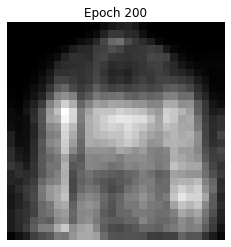

In [14]:
progress = progress.asnumpy()
images2gif(progress, "results/training_progress.gif")

In [15]:
Image(url="results/training_progress.gif")

Text(0.5, 1.0, 'Validation error (MSE)')

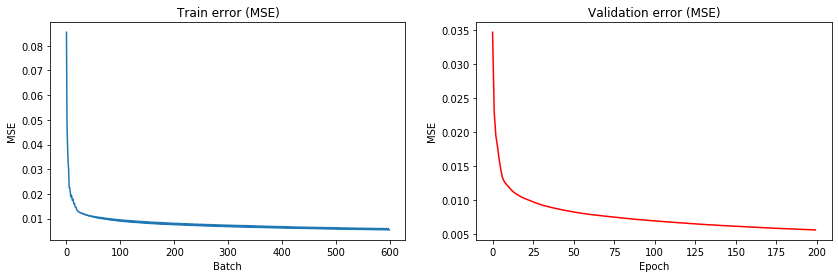

In [16]:
fig, (train_plot, valid_plot) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
train_plot.plot(train_losses)
train_plot.set_xlabel("Batch")
train_plot.set_ylabel("MSE")
train_plot.set_title("Train error (MSE)")

valid_plot.plot(valid_losses, c="red")
valid_plot.set_xlabel("Epoch")
valid_plot.set_ylabel("MSE")
valid_plot.set_title("Validation error (MSE)")

## 5. Evaluation

Now we evaluate our model against the test set. We should be able to get a denoised version of the noisy one.

In [17]:
for ((X_n, _), (X_o, _)) in zip(X_valid_noise, X_valid_orig):
    break
X_n = X_n.as_in_context(try_gpu())
X_o_hat = autoencoder(X_n)

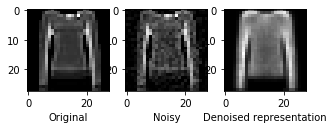

In [18]:
sample = 2

# Prepare image grid 1x3
titles = ["Original", "Noisy", "Denoised representation"]
imgs = np.array([
    X_o[sample][0, ::].asnumpy(),
    X_n[sample][0, ::].asnumpy(),
    X_o_hat[sample].reshape((28, 28)).asnumpy(),
])
plot_image_grid(imgs, 3, 1, titles)

## 6. Storing the model

Now we can save the model for further usage.

In [19]:
autoencoder.export("models/fashion-mnist", epoch=epochs)